## train_in_jupyter
This is a jupyter notebook file used to do training and see the loss during training. It is the same code with `train.py`.

### Import packages and initialize parameters

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Reshape, Conv2D, Input, Lambda
from keras.models import Model
from keras.optimizers import Adam

# from keras.applications import inception_v3, mobilenet
from keras.applications.mobilenet import MobileNet
from networks.MobileNet_v1 import MobileNetV1
from preprocessing import parse_annotation, BatchGenerator
from utils import read_category, decode_netout, draw_boxes

Using TensorFlow backend.


In [14]:
''' Initiailize parameters '''
LABELS = read_category()

IMAGE_H, IMAGE_W = 224, 224  # must equal to GRID_H * 32  416, 416
GRID_H, GRID_W = 7, 7 # 13, 13
N_BOX = 5
CLASS = len(LABELS)
CLASS_WEIGHTS = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

# Read knn generated anchor_5.txt
ANCHORS = []
with open('/Volumes/JS/UECFOOD100_JS/generated_anchors_mobilenet/anchors_5.txt', 'r') as anchor_file:
    for i, line in enumerate(anchor_file):
        line = line.rstrip('\n')
        ANCHORS.append(list(map(float, line.split(', '))))
ANCHORS = list(list(np.array(ANCHORS).reshape(1, -1))[0])

NO_OBJECT_SCALE = 1.0
OBJECT_SCALE = 5.0
COORD_SCALE = 1.0
CLASS_SCALE = 1.0

BATCH_SIZE = 16
WARM_UP_BATCHES = 100
TRUE_BOX_BUFFER = 15

generator_config = {
    'IMAGE_H': IMAGE_H,
    'IMAGE_W': IMAGE_W,
    'GRID_H': GRID_H,
    'GRID_W': GRID_W,
    'BOX': N_BOX,
    'LABELS': LABELS,
    'CLASS': len(LABELS),
    'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

all_imgs = []
for i in range(0, len(LABELS)):
    image_path = '/Volumes/JS/UECFOOD100_JS/' + str(i+1) + '/'
    annot_path = '/Volumes/JS/UECFOOD100_JS/' + str(i+1) + '/' + '/annotations_new/'

    folder_imgs, seen_labels = parse_annotation(annot_path, image_path)
    all_imgs.extend(folder_imgs)
print(np.array(all_imgs).shape)

# add extensions to image name
for img in all_imgs:
    img['filename'] = img['filename']

print('=> Generate BatchGenerator.')
batches = BatchGenerator(all_imgs, generator_config)

(14361,)
=> Generate BatchGenerator.


### Plot sample batch images to check if the annoations are correct  
- This step is crucial. As long as your annoations match with images the training would working towards the right direction.

In [50]:
def plt_example_batch(batches, batch_size=16):
    assert batches[0][0][0].shape[0] == batch_size       # in general 16x224x224x3
    for i in range(0, batch_size):
        img = batches[0][0][0][i]
        plt.figure(i)
        plt.imshow(img.astype('uint8'))

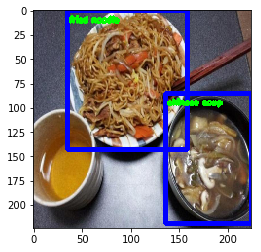

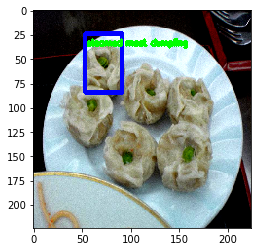

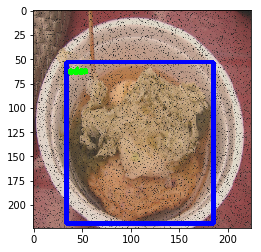

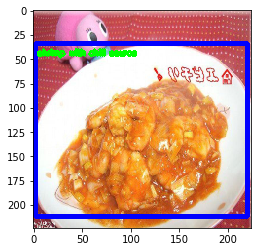

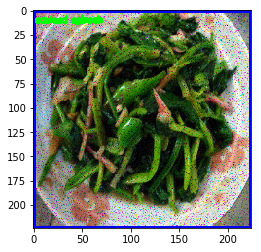

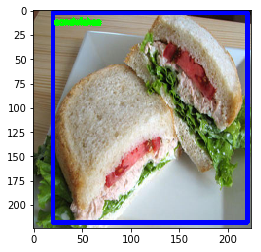

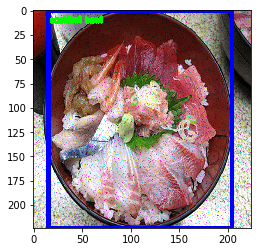

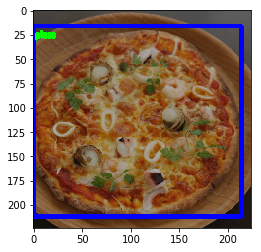

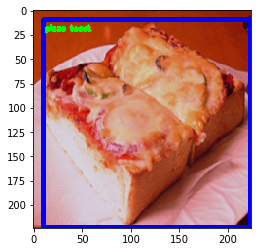

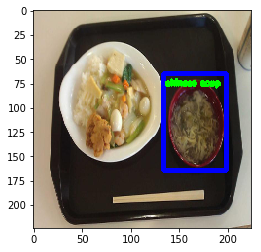

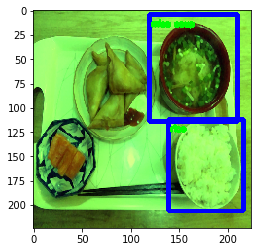

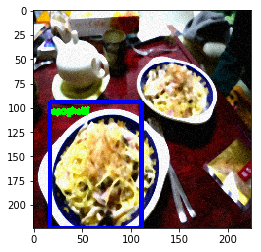

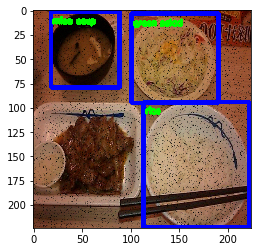

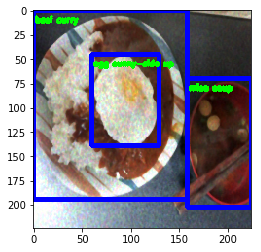

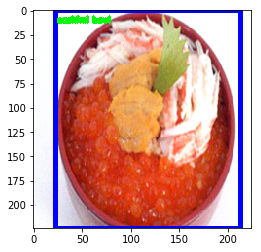

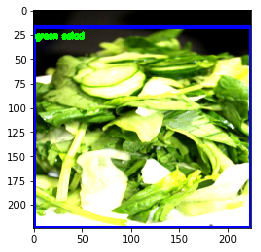

In [51]:
plt_example_batch(batches, BATCH_SIZE)

### Split dataset and get MobileNetV1 model

In [49]:
def normalize(image):
    return image / 255.

train_valid_split = int(0.8 * len(all_imgs))

train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=normalize, jitter=False)
valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=normalize, jitter=False)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

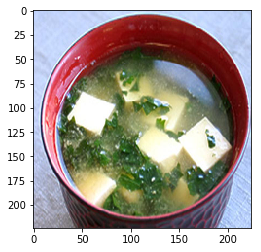

In [16]:
img = train_batch[0][0][0][1]
plt.imshow(img.astype('float'))  # beacuse of normalization

In [50]:
def get_model():
    """ Load localization model """
#     from keras.models import load_model
#     model = load_model('./models/model_foodvsnot_v3.h5')
#     print(model.summary())
    """ Build MobileNetV1 model """
    print('=> Building MobileNetV1 model...')
#     mobilenet = MobileNetV1(input_shape=(448, 448, 3), include_top=False) 

    mobilenet = MobileNet(input_shape=(224, 224, 3), include_top=False)
    x = mobilenet(input_image)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    return model

In [51]:
model = get_model()

=> Building MobileNetV1 model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Model)      (None, 7, 7, 1024)   3228864     input_14[0][0]                   
__________________________________________________________________________________________________
conv_23 (Conv2D)                (None, 7, 7, 525)    538125      mobilenet_1.00_224[1][0]         
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 7, 7, 5, 105) 0           conv_23[0][0]                    
____________________________________________________________________________

### Custome loss of YOLO

In [56]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]

    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0, 2, 1, 3, 4))

    cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])

    coord_mask = tf.zeros(mask_shape)
    conf_mask = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)

    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)

    """ Adjust prediction """
    # adjust x and y
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid

    # adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, N_BOX, 2])

    # adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])

    # adjust class probabilities
    pred_box_class = y_pred[..., 5:]

    """ Adjust ground truth """
    # adjust x and y
    true_box_xy = y_true[..., 0:2]  # relative position to the containing cell

    # adjust w and h
    true_box_wh = y_true[..., 2:4]  # number of cells accross, horizontally and vertically

    # adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins = true_box_xy - true_wh_half
    true_maxes = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins = pred_box_xy - pred_wh_half
    pred_maxes = pred_box_xy + pred_wh_half

    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = tf.truediv(intersect_areas, union_areas)

    true_box_conf = iou_scores * y_true[..., 4]

    # adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    """ Determine the masks """
    # coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE

    # confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE

    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE

    # class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE

    """ Warm-up training """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE / 2.)
    seen = tf.assign_add(seen, 1.)

    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES),
                                                   lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask,
                                                            true_box_wh + tf.ones_like(true_box_wh) * np.reshape(
                                                                ANCHORS, [1, 1, 1, N_BOX, 2]) * no_boxes_mask,
                                                            tf.ones_like(coord_mask)],
                                                   lambda: [true_box_xy,
                                                            true_box_wh,
                                                            coord_mask])

    """ Finalize the loss """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box = tf.reduce_sum(tf.to_float(conf_mask > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf = tf.reduce_sum(tf.square(true_box_conf - pred_box_conf) * conf_mask) / (nb_conf_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)

    loss = loss_xy + loss_wh + loss_conf + loss_class

    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """ Debugging code """
    current_recall = nb_pred_box / (nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall)

    loss = tf.Print(loss, [tf.zeros((1))], message='\nDummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall / seen], message='Average Recall \t', summarize=1000)

    return loss

### Start training

In [59]:
def train(model):

    layer = model.layers[-4]            # the last convolutional layer
    weights = layer.get_weights()

    new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
    new_bias = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)

    layer.set_weights([new_kernel, new_bias])

    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.001,
                               patience=3,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint('all_imgs_mobile_net_loss.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    # model.load_weights('./models/mobile_net_loss0_07.h5')

#     tb_counter = len([log for log in os.listdir(os.path.expanduser('./tf_logs/')) if 'food' in log]) + 1
#     tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'all_imgs_mobile_net' + '_' + str(tb_counter),
#                               histogram_freq=0,
#                               write_graph=True,
#                               write_images=False)

    # TODO: try different optimizer and tweak parameters (in MNv1 paper they used RMSprop)
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
    # optimizer = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss=custom_loss, optimizer=optimizer)

    model.fit_generator(generator=train_batch,
                        steps_per_epoch=len(train_batch),
                        epochs=20,  # 100
                        verbose=1,
                        validation_data=valid_batch,
                        validation_steps=len(valid_batch),
#                         callbacks=[early_stop, checkpoint, tensorboard],
                        callbacks=[early_stop, checkpoint],
                        max_queue_size=3)

In [60]:
train(model)

Epoch 1/20
299/718 [===========>..................] - ETA: 27:22 - loss: 23.9347

StopIteration: 'NoneType' object has no attribute 'shape'

In [59]:
model.load_weights('/Volumes/JS/all_imgs_mobile_net_valloss0_17.h5')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [32]:
from networks.my_inception_v3 import myInceptionV3
from keras.layers import UpSampling2D
from keras_applications.mobilenet import _depthwise_conv_block

def get_new_model():
    """ Build transferLearning model """
    print('=> Building transferLearning model...')
    small_incepv3 = myInceptionV3(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    # print('small_incepv3.summary()', small_incepv3.summary())
    small_incepv3 = Model(inputs=small_incepv3.inputs, outputs=small_incepv3.layers[-84].input)
    # print(small_incepv3.summary())
    x = small_incepv3(input_image)
    x = add_mn(x)
    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    return model


def add_mn(x):
    alpha, depth_multiplier = 1, 1
    x = UpSampling2D(2)(x)    # 56x56
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 768, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    return x

In [33]:
model = get_new_model()

=> Building transferLearning model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 28, 28, 768)  8975264     input_10[0][0]                   
__________________________________________________________________________________________________
up_sampling2d_9 (UpSampling2D)  (None, 56, 56, 768)  0           model_7[1][0]                    
__________________________________________________________________________________________________
conv_pad_3 (ZeroPadding2D)      (None, 58, 58, 768)  0           up_sampling2d_9[0][0]            
_______________________________________________________________________

In [34]:
from keras_applications.mobilenet import _depthwise_conv_block
from keras_applications.mobilenet_v2 import _inverted_res_block
def get_pretrained_mn1():
    alpha, depth_multiplier = 1, 1
    print('=> Building new model with pretrained MobilenetV1...')

    pretrained_gap_model = load_model('./models/gap_foodnotfood_mn1_224.h5')
#     print(pretrained_gap_model.summary())
    model = Model(inputs=pretrained_gap_model.input, outputs=pretrained_gap_model.layers[-6].input)
#     print(model.summary())
    x = model(input_image)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    x = Conv2D(N_BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, N_BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    print(model.summary())
    print('Finish new model.')
    return model

In [35]:
# model.load_weights('./transferLearning_mn_224_0_06564.h5')
from keras.models import Model, load_model
# model = load_model('./transferLearning_mn_224_0_06564.h5')
model = get_pretrained_mn1()

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

=> Building new model with pretrained MobilenetV1...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 14, 14, 512)  1627840     input_11[0][0]                   
__________________________________________________________________________________________________
conv_pad_12 (ZeroPadding2D)     (None, 16, 16, 512)  0           model_4[1][0]                    
__________________________________________________________________________________________________
conv_dw_12 (DepthwiseConv2D)    (None, 7, 7, 512)    4608        conv_pad_12[0][0]                
________________________________________________________

In [53]:
# model.load_weights('./models/transferLearning_mn_224.h5')
model.load_weights('./models/all_imgs_mobile_net_valloss0_17.h5')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

/Users/jianingsun/Documents/GitHub/Object-Detection-YOLO-/mn_object_detection/utils.py:203: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


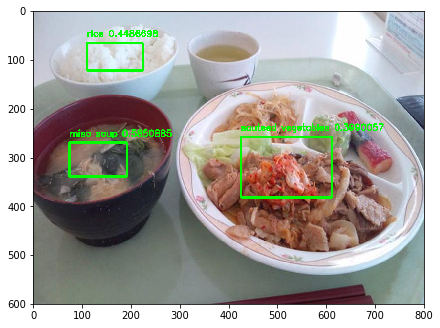

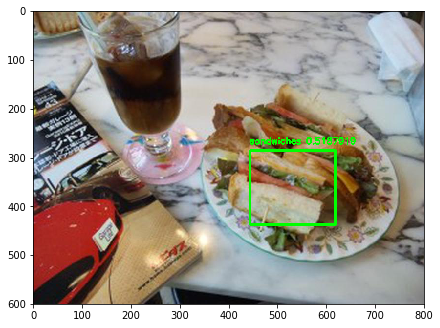

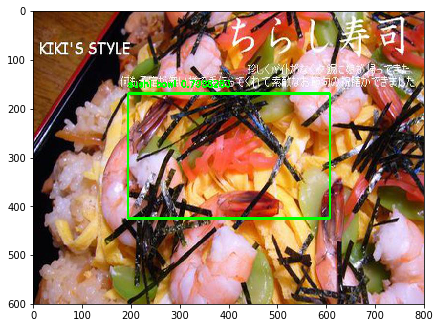

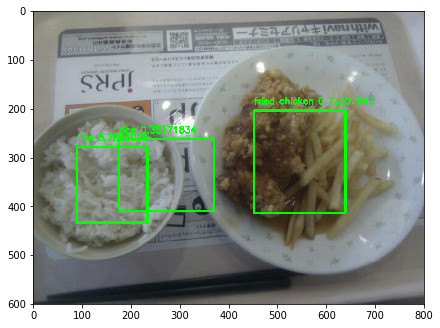

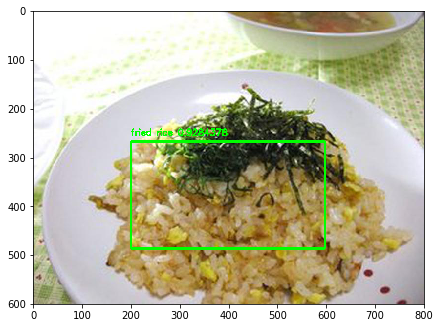

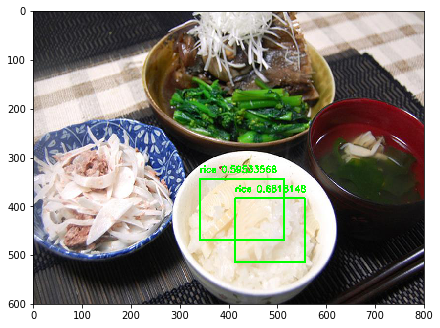

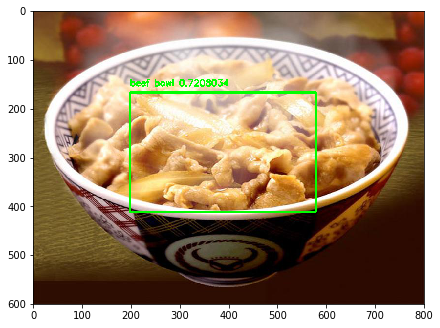

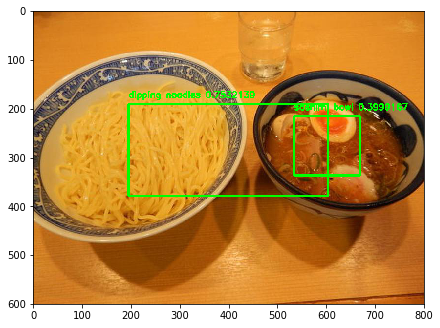

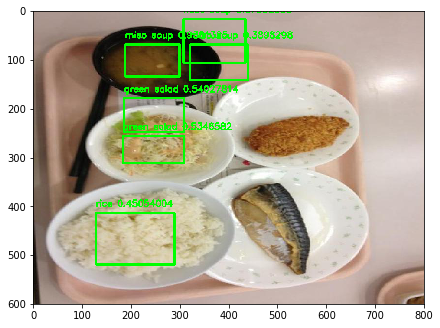

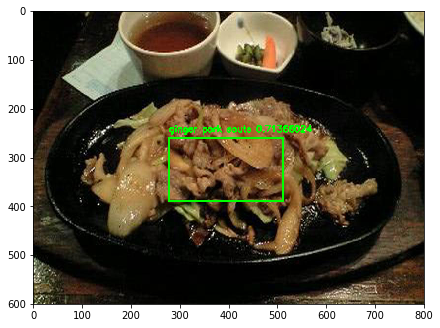

In [60]:
import cv2
# image = cv2.imread('/Volumes/JS/UECFOOD100_JS/1/2.jpg')
# image = cv2.imread('./multirice_test.jpg')
for i in range(0, 10):
    image = cv2.imread(all_imgs[:train_valid_split][i]['filename'])
#     image = cv2.imread(all_imgs[train_valid_split:][i]['filename'])

    plt.figure(i, figsize=(7,7))

    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    plt.imshow(image[:,:,::-1])
    plt.imsave('mn_result_0924.png', image[:,:,::-1])
    plt.show()
    
# only test the multi-rice image
# image = cv2.imread('./multirice_test.jpg')
# plt.figure(1, figsize=(7,7))

# input_image = cv2.resize(image, (224, 224))
# input_image = input_image / 255.
# input_image = input_image[:,:,::-1]
# input_image = np.expand_dims(input_image, 0)

# netout = model.predict([input_image, dummy_array])

# boxes = decode_netout(netout[0], 
#                       obj_threshold=0.3,
#                       nms_threshold=NMS_THRESHOLD,
#                       anchors=ANCHORS, 
#                       nb_class=CLASS)
# image = draw_boxes(image, boxes, labels=LABELS)

# plt.imshow(image[:,:,::-1])
# plt.imsave('mn_result_0924.png', image[:,:,::-1])
# plt.show()